# 7 Test Model

## 7.1 Install and loaf libraries

In [53]:
!pip install wandb
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score

In [55]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 7.2 Teste Evaluation

### 7.2.1 Base functions definition

This is necessary in order to joblib.load() see the previous definitions used in the Train Pipeline

In [56]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = tf.keras.layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

### 7.2.2 Evaluation

In [57]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "phishing-detection-2/test.csv:latest"

# name of the model artifact
artifact_model_name = "phishing-detection-2/model_export:latest"

In [58]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S")

# reference for a logging obj
logger = logging.getLogger()

In [59]:
# initiate the wandb project
run = wandb.init(project="phishing-detection-2",job_type="test")

In [60]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
df_test['target'] = np.where(df_test['status']=='legitimate', 0., 1.)

logger.info("Droping columns 'status' and 'url'")
df_test = df_test.drop(columns=['status', 'url'])

test_ds = df_to_dataset(df_test,shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [61]:
# Takes a look at test set
df_test.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,target
0,24,17,0,2,0,0,0,0,0,0,...,1,1,0,278,3374,0,0,1,1,1.0
1,56,19,0,2,0,0,0,0,0,0,...,0,0,0,841,7559,1695,0,1,7,0.0
2,69,10,0,2,1,0,0,0,0,0,...,1,1,0,313,783,0,0,1,1,1.0
3,55,16,0,3,1,0,0,0,0,0,...,0,0,1,0,-1,9075,0,0,6,0.0
4,47,16,0,2,0,0,0,0,0,0,...,0,1,0,903,7132,12,0,0,7,0.0


In [62]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
model = joblib.load(model_export_path)

In [63]:
# predict
logger.info("Infering")
loss, accuracy = model.evaluate(test_ds)

logger.info("Accuracy: {}".format(accuracy))
logger.info("Loss: {}".format(loss))

72/72 [==============================] - 2s 9ms/step - loss: 0.0369 - accuracy: 0.9541


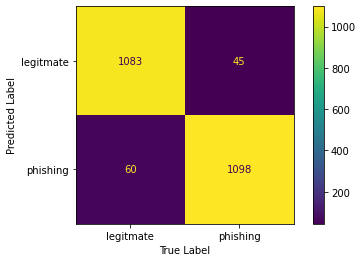

In [68]:
predict = model.predict(test_ds)

pred = []
targ = []

for i in range(0,len(predict)):
    targ.append(1.0 if df_test['target'][i] == 1.0 else 0.0)
    pred.append(1.0 if predict[i] >= 0.5 else 0.0)

labels = ["legitimate", "phishing"]

fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(pred,targ,labels=[1,0]),
                       display_labels=["legitmate","phishing"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(targ, pred, beta=1, zero_division=1)
precision = precision_score(targ, pred, zero_division=1)
recall = recall_score(targ, pred, zero_division=1)
acc = accuracy_score(targ, pred)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [69]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [70]:
run.finish()

Acc,0.95407
F1,0.95376
Precision,0.96011
Recall,0.94751
